In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("wine-clustering.csv")
df.head(10).style.set_properties(**{'background-color': 'hotpink', 'color': '#000', 'border': '1px solid #000000'})

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.230000,1.710000,2.430000,15.600000,127,2.800000,3.060000,0.280000,2.290000,5.640000,1.040000,3.920000,1065
1,13.200000,1.780000,2.140000,11.200000,100,2.650000,2.760000,0.260000,1.280000,4.380000,1.050000,3.400000,1050
2,13.160000,2.360000,2.670000,18.600000,101,2.800000,3.240000,0.300000,2.810000,5.680000,1.030000,3.170000,1185
3,14.370000,1.950000,2.500000,16.800000,113,3.850000,3.490000,0.240000,2.180000,7.800000,0.860000,3.450000,1480
4,13.240000,2.590000,2.870000,21.000000,118,2.800000,2.690000,0.390000,1.820000,4.320000,1.040000,2.930000,735
5,14.200000,1.760000,2.450000,15.200000,112,3.270000,3.390000,0.340000,1.970000,6.750000,1.050000,2.850000,1450
6,14.390000,1.870000,2.450000,14.600000,96,2.500000,2.520000,0.300000,1.980000,5.250000,1.020000,3.580000,1290
7,14.060000,2.150000,2.610000,17.600000,121,2.600000,2.510000,0.310000,1.250000,5.050000,1.060000,3.580000,1295
8,14.830000,1.640000,2.170000,14.000000,97,2.800000,2.980000,0.290000,1.980000,5.200000,1.080000,2.850000,1045
9,13.860000,1.350000,2.270000,16.000000,98,2.980000,3.150000,0.220000,1.850000,7.220000,1.010000,3.550000,1045


In [3]:
df.tail()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.7,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.3,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.2,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.3,0.60,1.62,840
177,14.13,4.10,2.74,24.5,96,2.05,0.76,0.56,1.35,9.2,0.61,1.60,560


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


In [40]:
df.columns.to_list()

['Alcohol',
 'Malic_Acid',
 'Ash',
 'Ash_Alcanity',
 'Magnesium',
 'Total_Phenols',
 'Flavanoids',
 'Nonflavanoid_Phenols',
 'Proanthocyanins',
 'Color_Intensity',
 'Hue',
 'OD280',
 'Proline',
 'Cluster',
 'Labels']

In [6]:
df.describe()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [8]:
print(f"Shape: {df.shape}")

Shape: (178, 13)


In [9]:
df.size

2314

In [41]:
df.isna().sum()

,0
Alcohol,0
Malic_Acid,0
Ash,0
Ash_Alcanity,0
Magnesium,0
Total_Phenols,0
Flavanoids,0
Nonflavanoid_Phenols,0
Proanthocyanins,0
Color_Intensity,0


In [11]:
print("Duplicates:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

Duplicates: 0


In [12]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound,df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound,df[column])

{'whiskers': [<matplotlib.lines.Line2D at 0x7d3f3b9d2a10>,
 'caps': [<matplotlib.lines.Line2D at 0x7d3f3bb3d410>,
 'boxes': [<matplotlib.lines.Line2D at 0x7d3f3bb54e10>,
 'medians': [<matplotlib.lines.Line2D at 0x7d3f3b9dd3d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7d3f3b9ddd10>,
 'means': []}

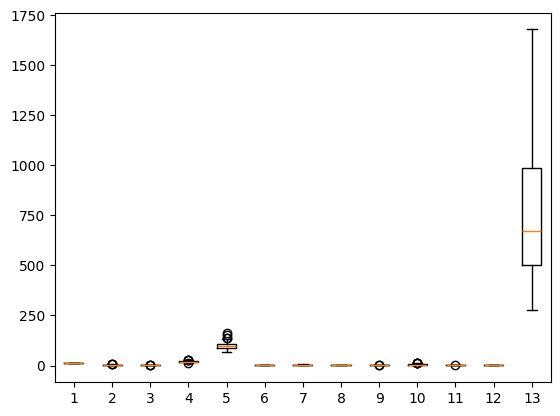

In [13]:
plt.boxplot(df)

In [14]:
remove_outliers(df,["Malic_Acid"])

In [15]:
for column in df.columns:
   remove_outliers(df, column)

In [16]:
df.shape

(178, 13)

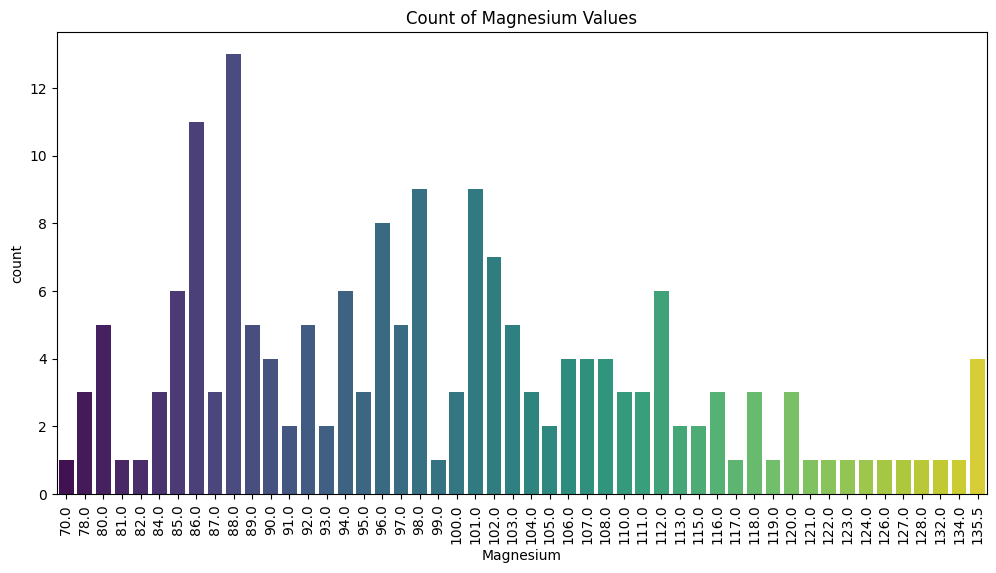

In [17]:
plt.figure(figsize=(12,6))
sns.countplot(x='Magnesium', data=df, palette='viridis')
plt.title('Count of Magnesium Values')
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='Proline', ylabel='Count'>

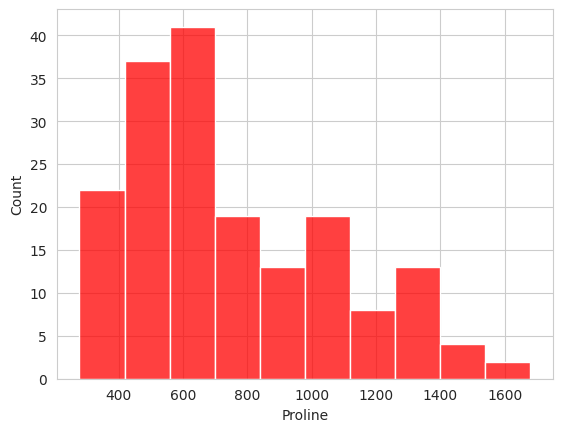

In [18]:
sns.set_style('whitegrid')
sns.histplot(df['Proline'],color ='red', bins = 10)

<Axes: xlabel='Color_Intensity', ylabel='Count'>

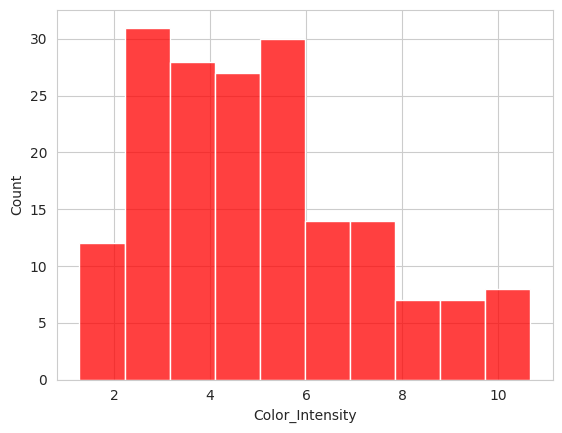

In [19]:
sns.set_style('whitegrid')
sns.histplot(df['Color_Intensity'],color ='red', bins = 10)

In [20]:
fig = px.scatter(df, x="Color_Intensity", y="Alcohol")
fig.show()

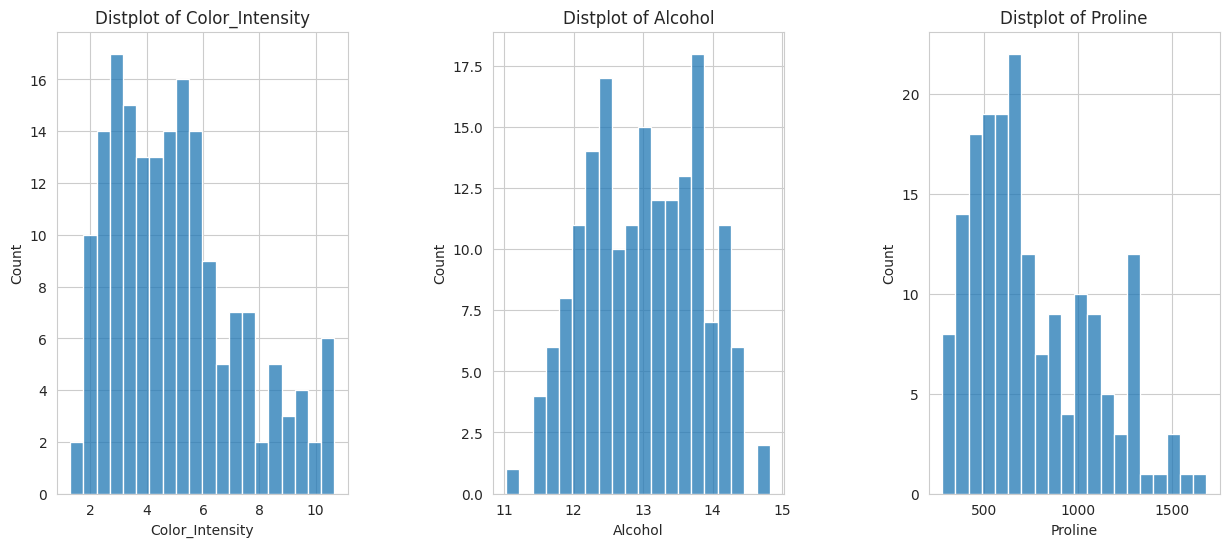

In [21]:
plt.figure(figsize = (15 , 6))
n = 0
for x in ['Color_Intensity' , 'Alcohol' , 'Proline']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.histplot(df[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show();

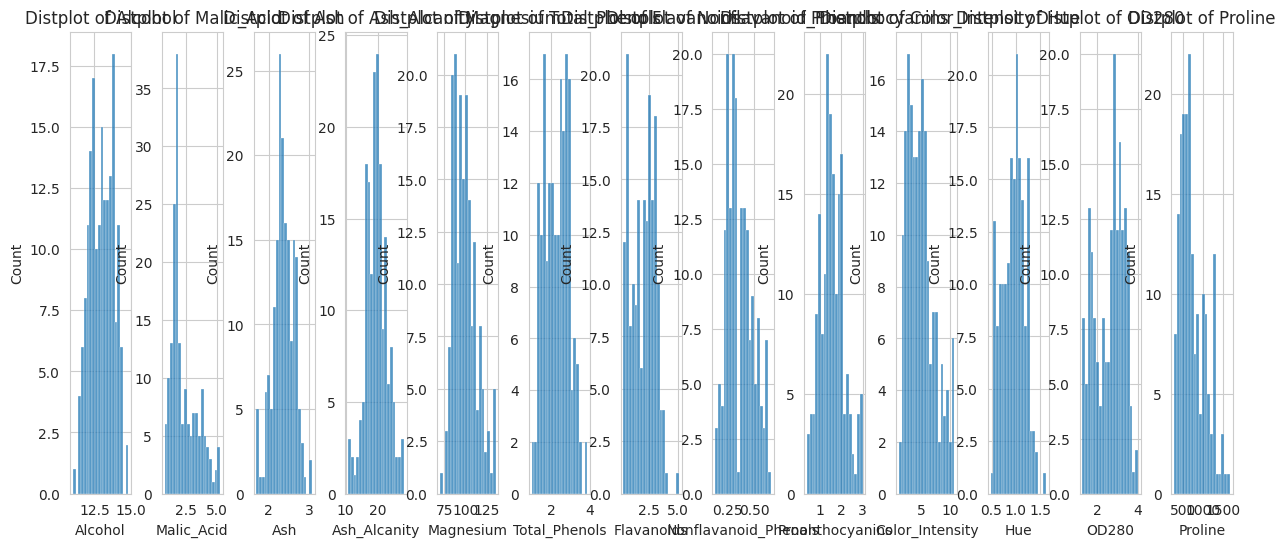

In [22]:
plt.figure(figsize = (15 , 6))
n = 0
for x in df:
    n += 1
    plt.subplot(1 , 13 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.histplot(df[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show();

Text(0, 0.5, 'Count')

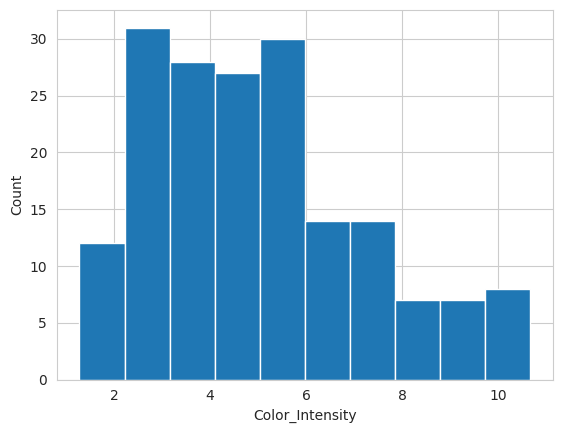

In [42]:
df['Color_Intensity'].hist()
plt.xlabel('Color_Intensity')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

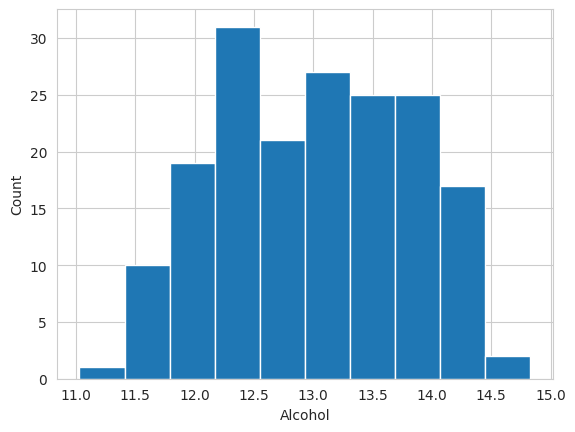

In [43]:
df['Alcohol'].hist()
plt.xlabel('Alcohol')
plt.ylabel('Count')

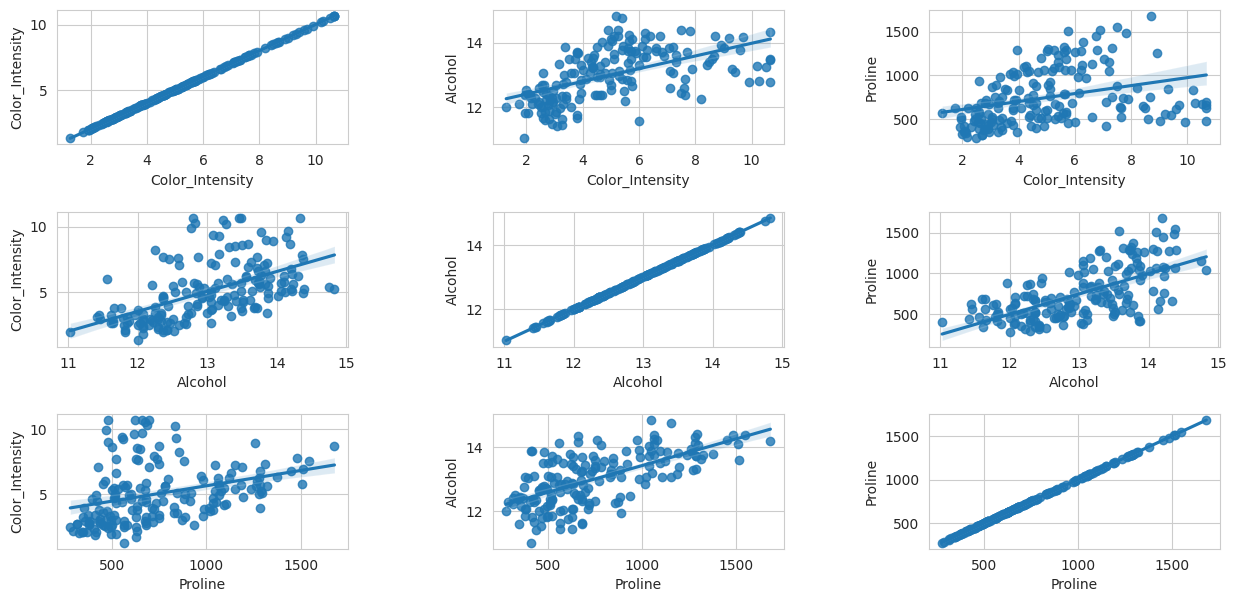

In [25]:
plt.figure(1 , figsize = (15 , 7))
n = 0
for x in ['Color_Intensity' , 'Alcohol' , 'Proline']:
    for y in ['Color_Intensity' , 'Alcohol' , 'Proline']:
        n += 1
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
plt.show()

**Alcohol and Proline show a strong positive correlation, it means wines with more alcohol tend to have more proline.alcohol content has some influence on color intensity**

In [26]:
fig = px.scatter(df,
                 x="Alcohol",
                 y="Color_Intensity",
                 height=400)

fig.update_traces(marker={'size': 10})
fig.update_layout(title="Alcohol vs Color Intensity", title_x=0.5,
                  xaxis_title="Alcohol",
                  yaxis_title="Color Intensity")

fig.show()

In [27]:
X = df.iloc[: , [9,12]]
print(f"X Shape {X.shape}")
X.head()

X Shape (178, 2)


,Color_Intensity,Proline
0,5.64,1065.0
1,4.38,1050.0
2,5.68,1185.0
3,7.80,1480.0
4,4.32,735.0


In [28]:
n_clusters = range(2 , 13)
inertia_errors = []
silhouette_scores = []
# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    model = KMeans(n_clusters= k , random_state= 42)
    #TRAIN MODEL
    model.fit(X)
    #CALCULATE INERTIA
    inertia_errors.append(model.inertia_)
    #CALCULATE SILHOUETTE SCORE
    silhouette_scores.append(silhouette_score(X , model.labels_))
print("Inertia:", inertia_errors[:3])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [4508771.069491367, 2673803.8364540422, 1320102.2165761886]

Silhouette Scores: [np.float64(0.6604087033358418), np.float64(0.5908585798787348), np.float64(0.5785771097259162)]


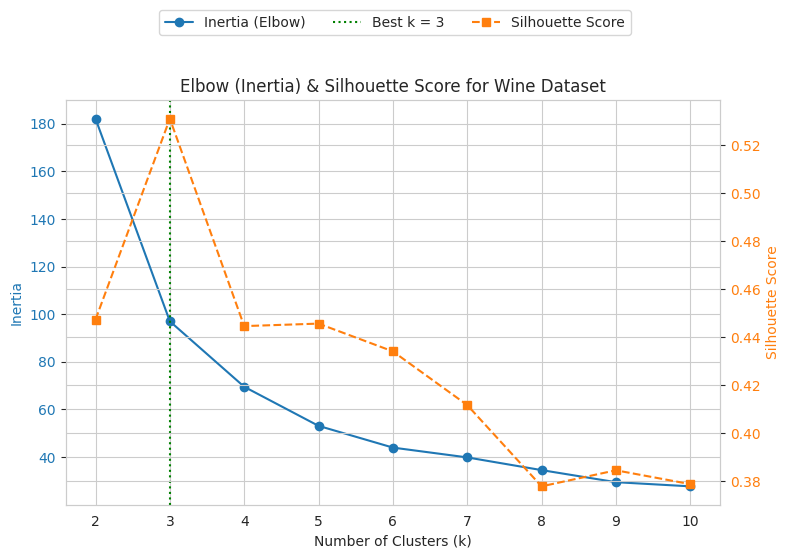

In [29]:
X = df[['Color_Intensity', 'Proline']]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Range of cluster numbers to test
ks = range(2, 11)
inertias = []
sil_scores = []

# Calculate Inertia & Silhouette score for each k
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plotting
fig, ax1 = plt.subplots(figsize=(8, 5))

# Elbow (Inertia)
color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(ks, inertias, 'o-', color=color, label='Inertia (Elbow)')
ax1.tick_params(axis='y', labelcolor=color)

# Silhouette Score (secondary axis)
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(ks, sil_scores, 's--', color=color, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color)

# Best k from Silhouette Score
best_k = ks[np.argmax(sil_scores)]
ax1.axvline(best_k, ls=':', color='green', label=f'Best k = {best_k}')

# Title & legends
plt.title('Elbow (Inertia) & Silhouette Score for Wine Dataset')
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.12), ncol=3)

plt.tight_layout()
plt.show()

In [30]:
final_model = KMeans(n_clusters=3 , random_state= 42)
final_model.fit(X)

KMeans(n_clusters=3, random_state=42)

In [31]:
labels = final_model.labels_
centroids = final_model.cluster_centers_
print(labels[:3])

[1 1 2]


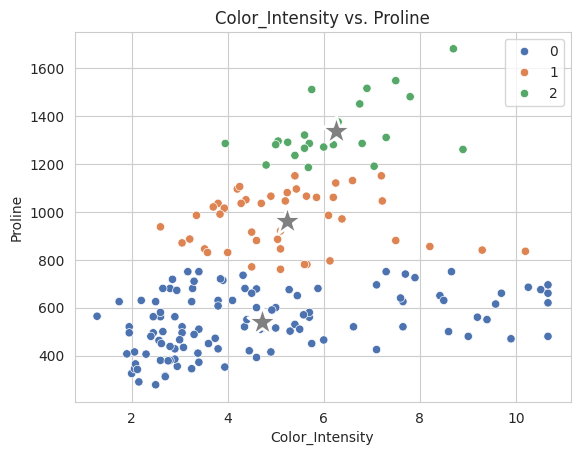

In [32]:
sns.scatterplot(x=df['Color_Intensity'] , y= df['Proline'] ,
               hue=labels,
               palette='deep')
sns.scatterplot(
    x= centroids[:,0],
    y= centroids[: ,1],
    color= 'gray',
    marker= '*',
    s= 500
)
plt.xlabel("Color_Intensity")
plt.ylabel("Proline")
plt.title("Color_Intensity vs. Proline");

Silhouette Score: 0.531
Davies-Bouldin Score: 0.636


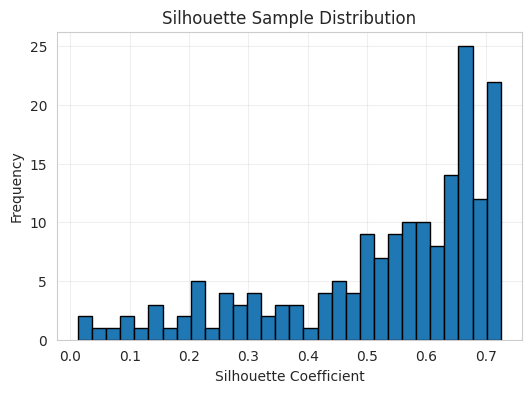

In [33]:
km = KMeans(n_clusters=best_k, random_state=42)
df['Cluster'] = km.fit_predict(X_scaled)

# Compute clustering quality metrics
sil = silhouette_score(X_scaled, df['Cluster'])
db_score = davies_bouldin_score(X_scaled, df['Cluster'])

print(f"Silhouette Score: {sil:.3f}")
print(f"Davies-Bouldin Score: {db_score:.3f}")

# Compute silhouette samples for distribution plot
sample_sil = silhouette_samples(X_scaled, df['Cluster'])

# Plot histogram of silhouette coefficients
plt.figure(figsize=(6, 4))
plt.hist(sample_sil, bins=30, edgecolor='k')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Frequency')
plt.title('Silhouette Sample Distribution')
plt.grid(alpha=0.3)
plt.show()

In [34]:
df['Cluster'] = labels  # from the corrected 2D KMeans above

# Group by cluster and get descriptive stats
cluster_profile = df.groupby('Cluster')[['Color_Intensity', 'Proline']].agg(
    Count=('Color_Intensity', 'size'),
    Mean_Color_Intensity=('Color_Intensity', 'mean'),
    Mean_Proline=('Proline', 'mean'),
    Min_Color_Intensity=('Color_Intensity', 'min'),
    Max_Color_Intensity=('Color_Intensity', 'max'),
    Min_Proline=('Proline', 'min'),
    Max_Proline=('Proline', 'max')
).reset_index()

print(cluster_profile)

   Cluster  Count  Mean_Color_Intensity  Mean_Proline  Min_Color_Intensity  \
0        0    111              4.705225    539.072072                 1.28   
1        1     44              5.239318    961.886364                 2.60   
2        2     23              6.260000   1338.565217                 3.95   

   Max_Color_Intensity  Min_Proline  Max_Proline  
0                10.67        278.0        750.0  
1                10.20        760.0       1150.0  
2                 8.90       1185.0       1680.0  


In [35]:
xgb= X.groupby(final_model.labels_).mean()
fig = px.bar(
    xgb,
    barmode= 'group',
    title= "Color_Intensity vs. Proline by Cluster"
)
fig.update_layout(xaxis_title= "Clusters" , yaxis_title= 'Value')

fig.show()

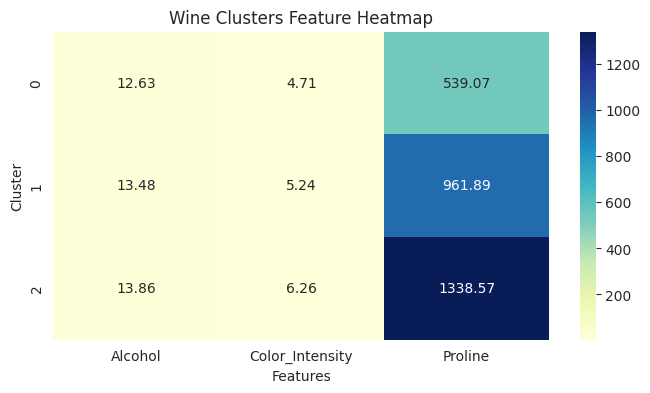

In [36]:
profile = df.groupby('Cluster')[['Alcohol', 'Color_Intensity', 'Proline']].mean().reset_index()
heatmap_data = profile.set_index('Cluster')
plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Wine Clusters Feature Heatmap")
plt.xlabel("Features")
plt.ylabel("Cluster")
plt.show()

<Axes: >

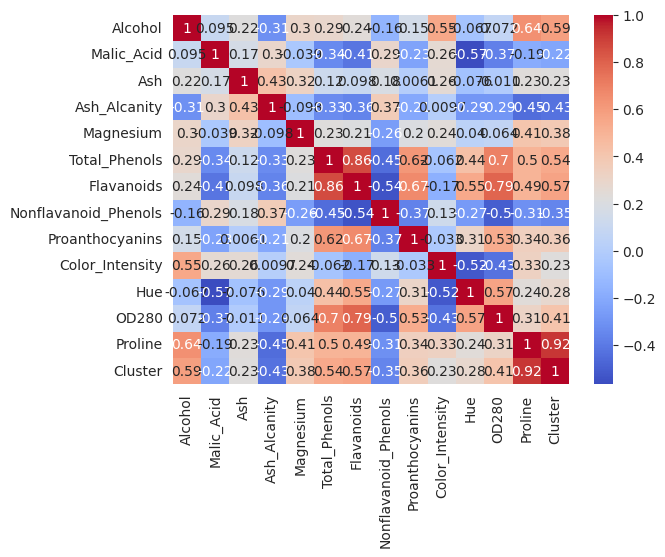

In [37]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

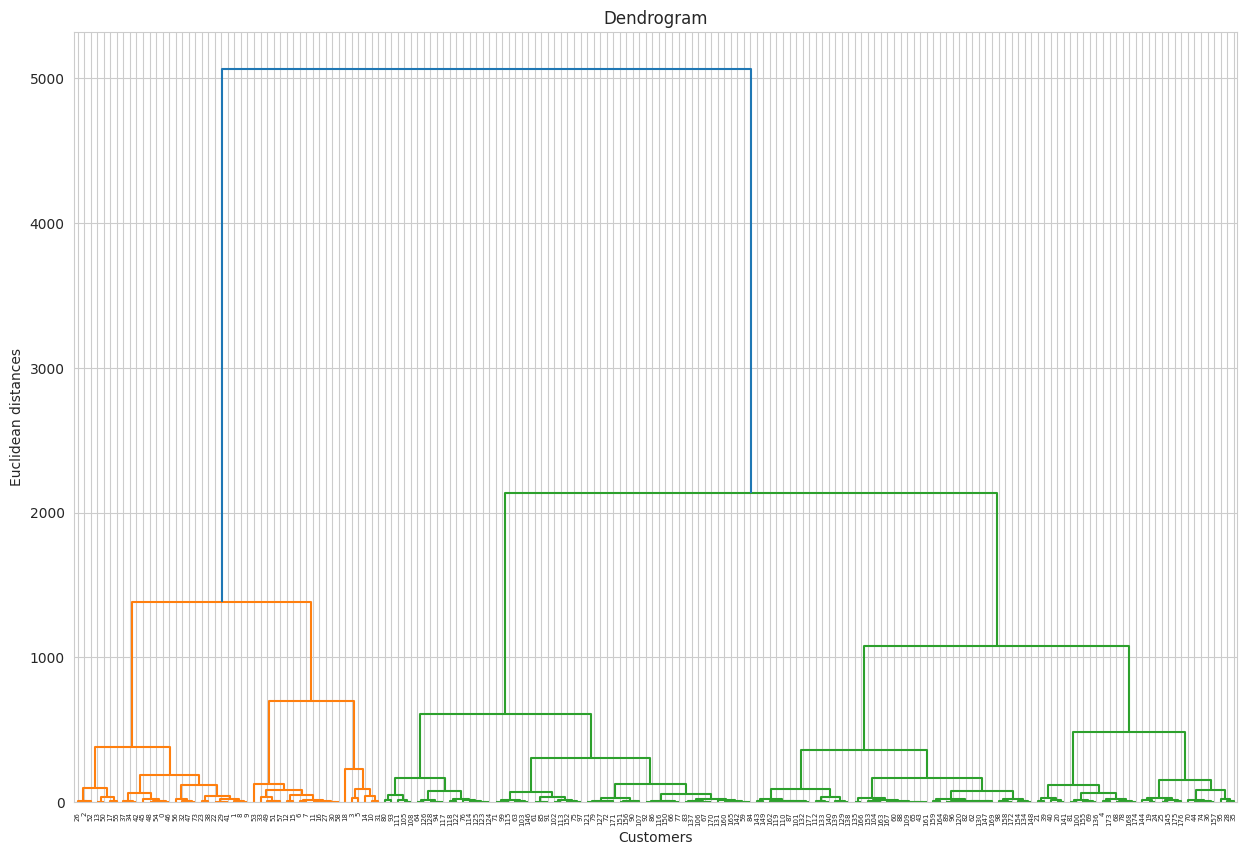

In [38]:
import scipy.cluster.hierarchy as sch
X = df[['Color_Intensity', 'Proline']]
plt.figure(figsize=(15,10))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.show()

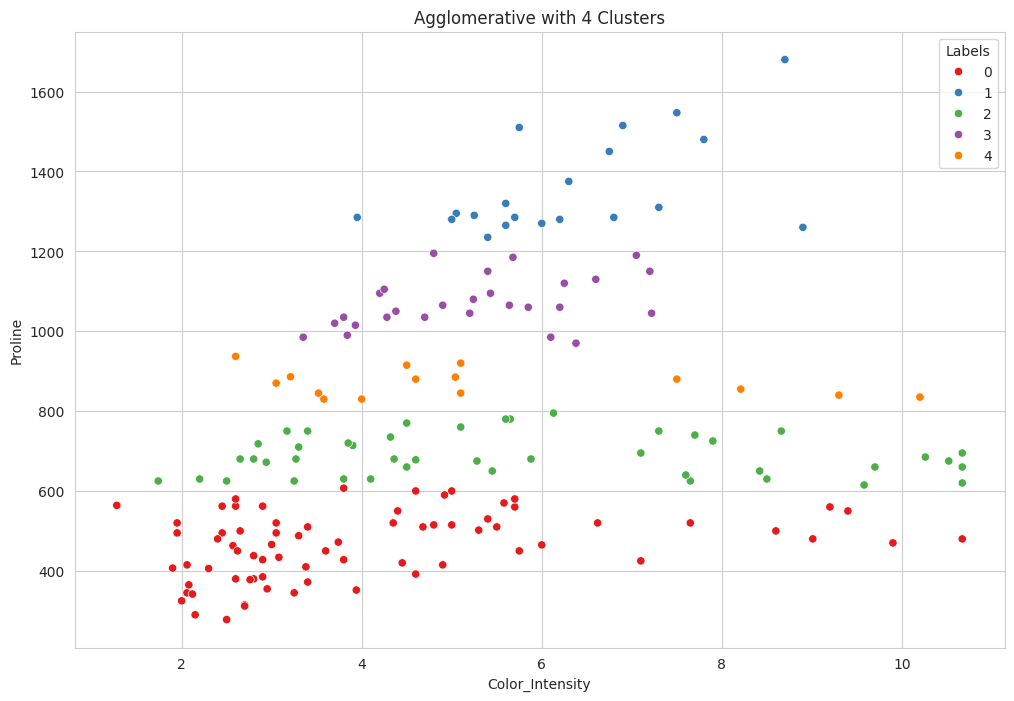

In [39]:
agglom = AgglomerativeClustering(n_clusters=5, metric = 'euclidean', linkage='ward')
y1 = agglom.fit_predict(df)
df['Labels'] = y1
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Color_Intensity', y='Proline', hue='Labels',
                  data=df, palette='Set1')
plt.title('Agglomerative with 4 Clusters')
plt.show()